# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import signal
import torch
import torchaudio
from torchaudio.functional import amplitude_to_DB
from torch.fft import fft, rfft, ifft
from nnAudio import Spectrogram
import pywt
from pathlib import Path

COMP_NAME = "g2net-gravitational-wave-detection"

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/{COMP_NAME}/")
OUTPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_output/{COMP_NAME}/")

In [2]:
df = pd.read_csv(INPUT_PATH / "training_labels.csv")
print(df.shape)
df.head(10)

(560000, 2)


,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
5,0000bb9f3e,1
6,0000c3b9c9,0
7,0000d61b7b,1
8,0001016d12,1
9,00010beb4a,1


In [3]:
df["target"].value_counts(normalize=True)

0    0.500125
1    0.499875
Name: target, dtype: float64

In [4]:
# wave_id = "098a464da9"  # Super clean signal
wave_id = "000a5b6e5c"
# wave_id = "00000e74ad"
# wave_id = "0000a38978"
# wave_id = "aeba158072"  # Mad clean signal
# wave_id = "af931f4263"  # Clean positive but predicted negative by EffNet-B5
# wave_id = "fef87c55fb"

# Analysis with GWPy

Taken from: https://www.kaggle.com/mistag/data-preprocessing-with-gwpy

https://www.gw-openscience.org/LVT151012data/LOSC_Event_tutorial_LVT151012.html

In [5]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from PIL import Image

In [6]:
def read_file(id_, folder="train"):
    path = INPUT_PATH / folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
    data = np.load(path)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
    return d1, d2, d3

def plot_time_data(d1, d2, d3):
    plot = Plot(d1, d2, d3, separate=True, sharex=True, figsize=[12, 8])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plot.show()
    
def idx_from_id(id_):
    return df.query(f"id == '{id_}'").index[0]

/home/anjum/anaconda3/envs/kaggle/lib/python3.8/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


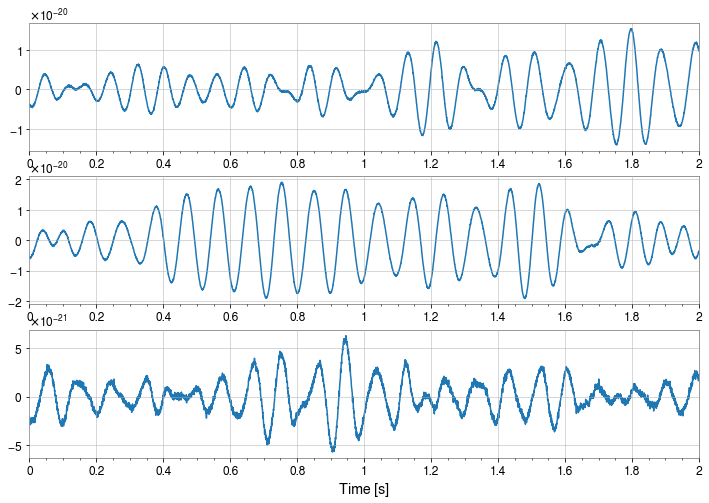

In [7]:
d1, d2, d3 = read_file(wave_id)
# https://www.kaggle.com/c/g2net-gravitational-wave-detection/discussion/263995
# d1, d2, d3 = read_file(df.loc[idx_from_id("ffff9a5645"), "id"])
plot_time_data(d1, d2, d3)

/home/anjum/anaconda3/envs/kaggle/lib/python3.8/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


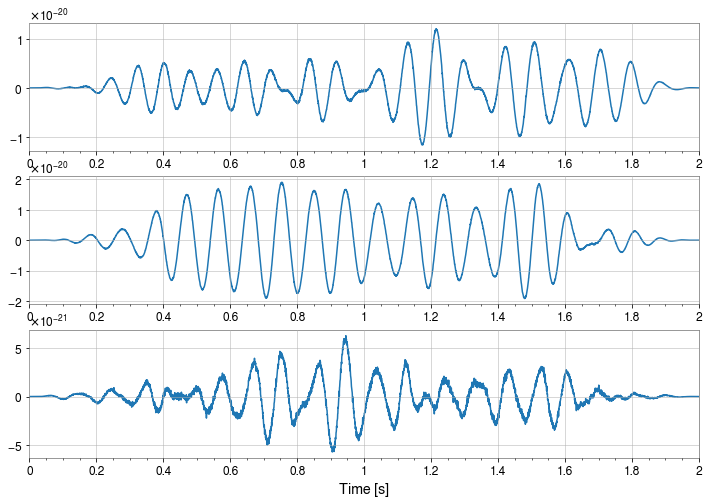

In [8]:
# Window function
window = signal.tukey(4096)

d1, d2, d3 = d1*window, d2*window, d3*window
plot_time_data(d1, d2, d3)

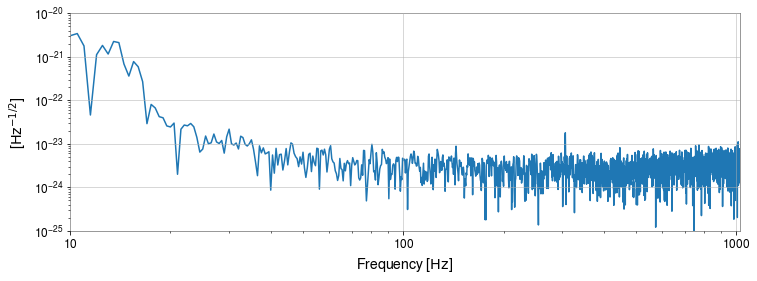

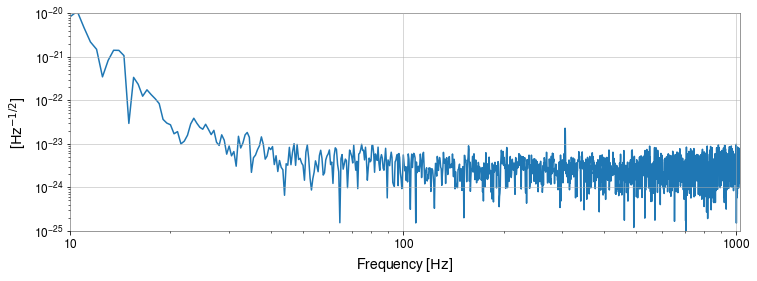

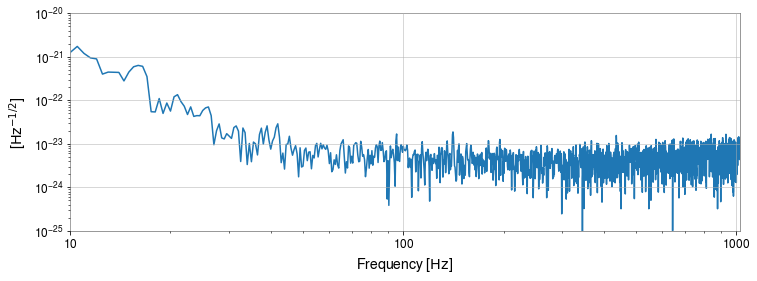

In [9]:
fig2 = d1.asd(fftlength=2).plot(figsize=[12, 4])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

fig2 = d2.asd(fftlength=2).plot(figsize=[12, 4])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

fig2 = d3.asd(fftlength=2).plot(figsize=[12, 4])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

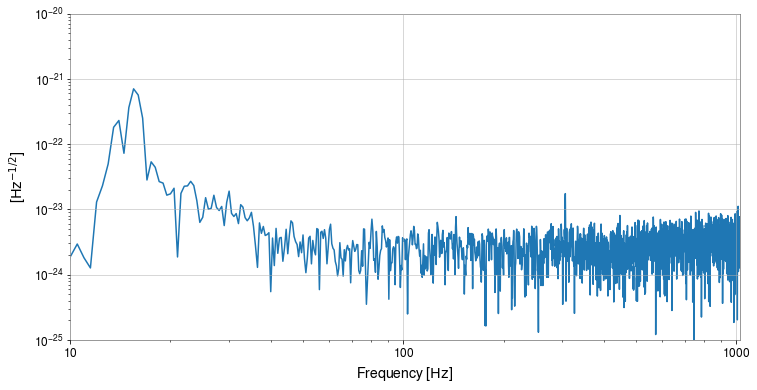

In [10]:
# Remove low freq noise using 15Hz highpass filter
fig2b = d1.highpass(15).asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

Text(0.5, 0, 'Time [s]')

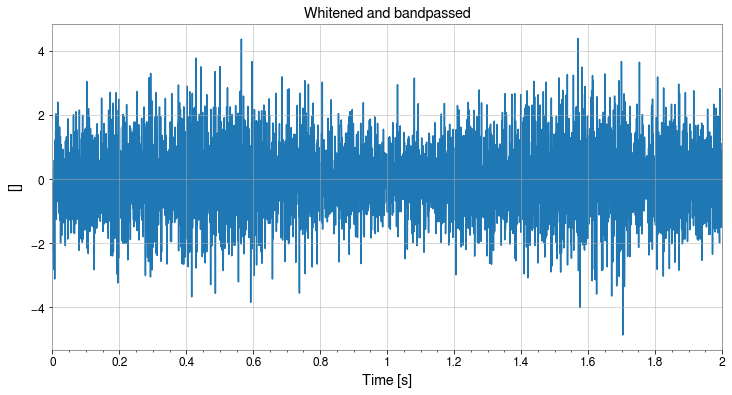

In [11]:
# Spectral whitening & bandpass filtering


# Whiten then BP
white_data = d2.whiten(
    window=("tukey", 0.2)
)  # whiten-function has a built-in window function
bp_data = white_data.bandpass(35, 1000)  # frequency range 35-350Hz
fig3 = bp_data.plot(figsize=[12, 6])
plt.xlim(0, 2)
ax = plt.gca()
ax.set_title("Whitened and bandpassed")
ax.set_xlabel("Time [s]")


# # BP then whiten
# bp_data = d2.bandpass(35, 1000)  # frequency range 35-350Hz
# white_data = bp_data.whiten(
#     window=("tukey", 0.2)
# )  # whiten-function has a built-in window function
# fig3 = white_data.plot(figsize=[12, 6])
# plt.xlim(0, 2)
# ax = plt.gca()
# ax.set_title("Bandpassed & whitened")
# ax.set_xlabel("Time [s]")

(10, 1024)

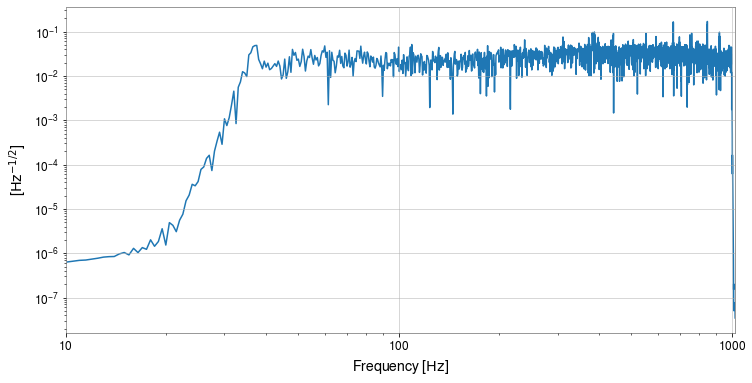

In [12]:
fig3 = bp_data.asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
# plt.ylim(1e-25, 1e-20);

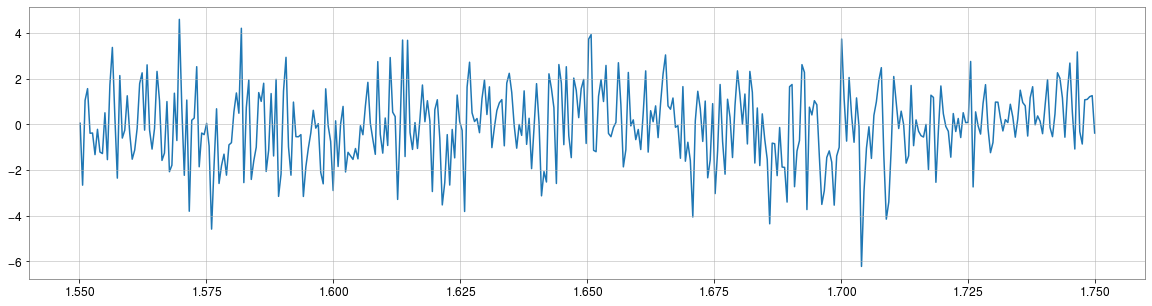

In [13]:
t = np.linspace(0, 2, 4096)
start = int(4096 * 1.55 / 2)
end = int(4096 * 1.75 / 2)

plt.figure(figsize=(20, 5))
plt.plot(t[start:end], white_data[start:end]);

In [14]:
# Complete preprocess function
def preprocess(d1, d2, d3, whiten=True, bandpass=False, lf=35, hf=1000, tukey_alpha=0.1):
    if whiten:
        white_d1 = d1.whiten(window=("tukey", tukey_alpha))
        white_d2 = d2.whiten(window=("tukey", tukey_alpha))
        white_d3 = d3.whiten(window=("tukey", tukey_alpha))
    else:
        window = signal.tukey(4096, tukey_alpha)
        white_d1, white_d2, white_d3 = d1*window, d2*window, d3*window
    if bandpass:  # bandpass filter
        bp_d1 = white_d1.bandpass(lf, hf)
        bp_d2 = white_d2.bandpass(lf, hf)
        bp_d3 = white_d3.bandpass(lf, hf)
        return bp_d1, bp_d2, bp_d3
    else:  # only whiten
        return white_d1, white_d2, white_d3

/home/anjum/anaconda3/envs/kaggle/lib/python3.8/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 1024.00 is too high for the given Q range, resetting to 893.09
  warnings.warn('upper frequency of %.2f is too high for the given '


(1000, 500)


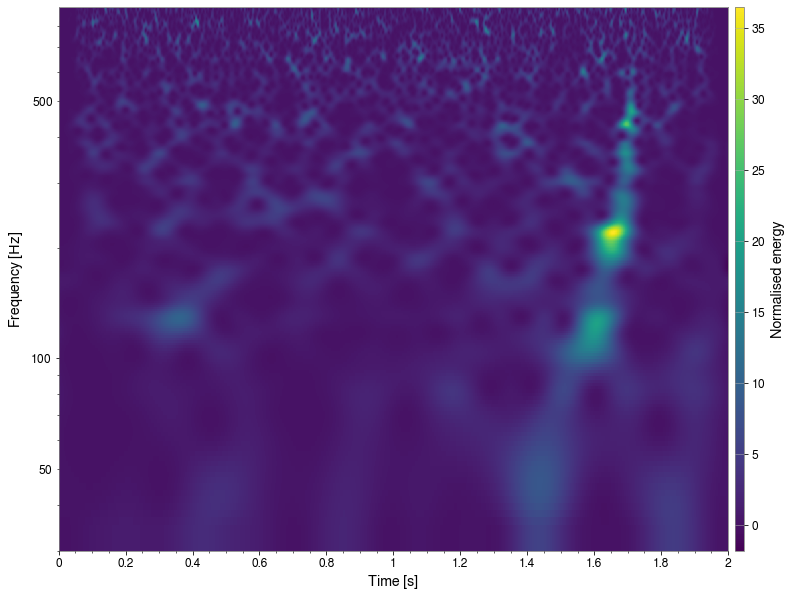

In [15]:
# Q-Transform

r1, r2, r3 = read_file(wave_id) # this signal has target=1
p1, p2, p3 = preprocess(r1, r2, r3, whiten=False, bandpass=False)
hq = p2.q_transform(qrange=(16,32), frange=(30,1024), logf=True, whiten=False)
print(hq.shape)
fig4 = hq.plot(figsize=[12, 10])
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Time [s]');

In [16]:
# Calculate 512x512 image
# r1, r2, r3 = read_file(wave_id)
# p1, p2, p3 = preprocess(r1, r2, r3, whiten=False, bandpass=False)
# hq2 = p2.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False, tres=2/512, fres=512)
# print(hq2.shape)
# fig4 = hq2.plot(figsize=[12, 10])
# ax = fig4.gca()
# fig4.colorbar(label="Normalised energy")
# ax.grid(False)
# ax.set_yscale('log')
# ax.set_xlabel('Time [s]');

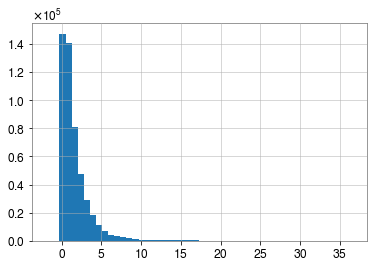

In [17]:
plt.hist(hq.flatten(), bins=50);

In [18]:
Q_RANGE = (16,32)
F_RANGE = (30,400)

def create_rgb(fname, whiten=True):
    r1, r2, r3 = read_file(fname)
    p1, p2, p3 = preprocess(r1, r2, r3, whiten=whiten)
    hq1 = p1.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq2 = p2.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq3 = p3.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    img = np.zeros([hq1.shape[0], hq1.shape[1], 3], dtype=np.uint8)
    print(img.shape)
    scaler = MinMaxScaler()
    img[:,:,0] = 255*scaler.fit_transform(hq1)
    img[:,:,1] = 255*scaler.fit_transform(hq2)
    img[:,:,2] = 255*scaler.fit_transform(hq3)
    return Image.fromarray(img).rotate(90, expand=1).resize((760,760))

(1000, 500, 3)


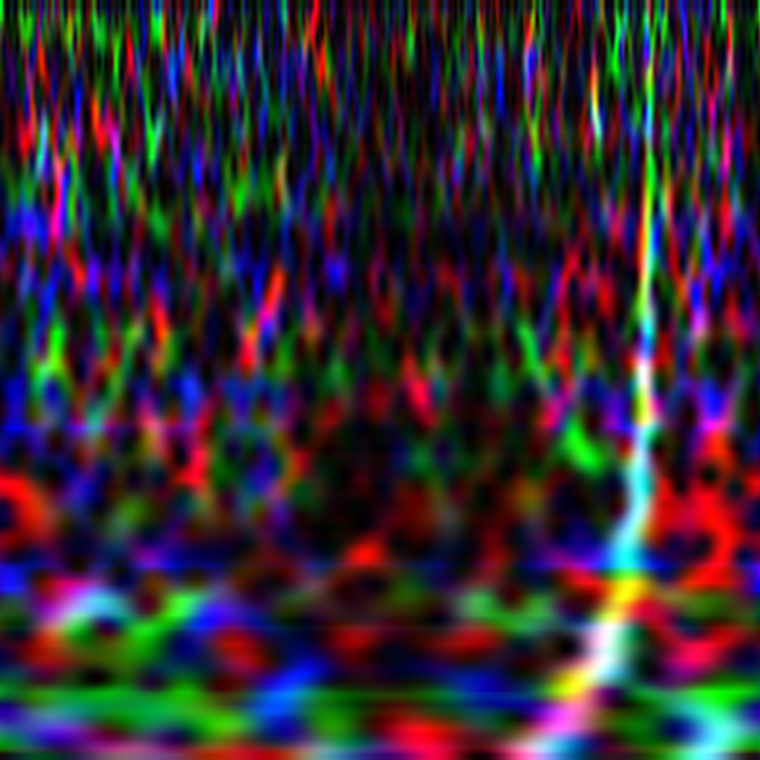

In [19]:
create_rgb(wave_id)

(1000, 500, 3)


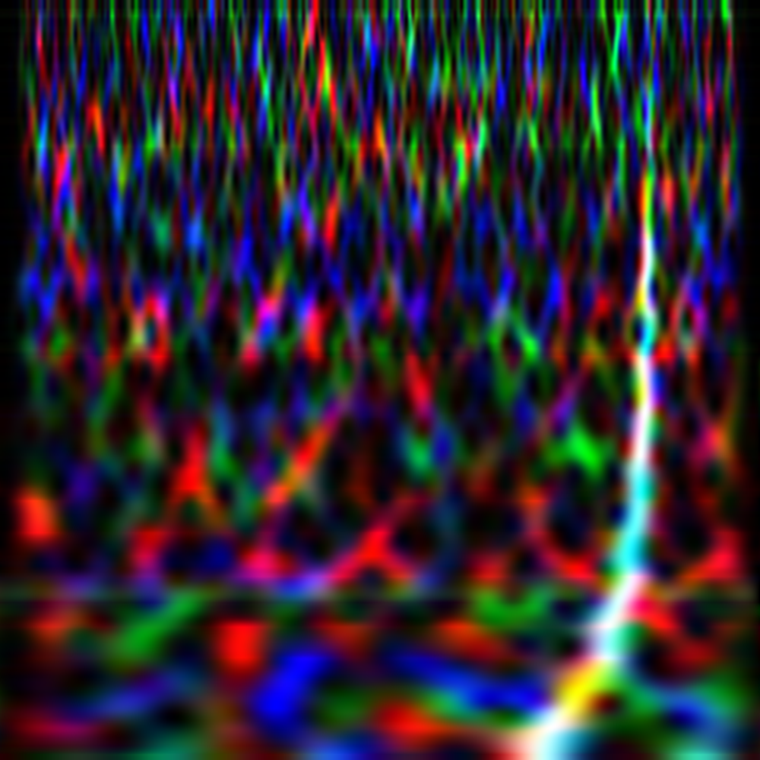

In [20]:
create_rgb(wave_id, False)

# Reproduce using `nnAudio`

In [21]:
def load_file(id_, folder="train"):
    path = INPUT_PATH / folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
    waves = np.load(path)
#     return waves / np.max(np.abs(waves), axis=1).reshape(3, 1)
    return waves / np.max(np.abs(waves))

[0.00613588 0.01840673 0.0306748  ... 0.0306748  0.01840673
 0.00613588]
(4096,)


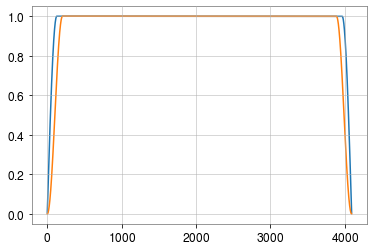

In [22]:
M = 256
win_tail = signal.windows.cosine(M, True)
win_flat = np.ones(4096 - M)
win = np.concatenate([win_tail[:M//2], win_flat, win_tail[-M//2:]])

print(win)
print(win.shape)
plt.plot(win);
plt.plot(signal.tukey(4096, 0.1));

In [23]:
SR = 2048
N = 4

transform_cqt = Spectrogram.CQT1992v2(
    sr=SR,
    fmin=30,
    fmax=1000,
    hop_length=8,  # img width = 4096 / hop_length
    bins_per_octave=12 * N,  # fs=0.5 & bpo=24 is the same as fs=1.0 and bpo=12 but with more rows (oversampling)
    filter_scale=1.0 / N,
#     norm=2,
    trainable=False,  # This is interesting...
#     window="parzen",
    window="flattop",
)

transform_fft = Spectrogram.STFT(
    n_fft=512,
    sr=SR,
    fmin=20,
    fmax=1000,
    hop_length=16,
    output_format="Magnitude",
    freq_scale="log",
    trainable=False,
    pad_mode="constant",
)


# https://www.kaggle.com/kevinmcisaac/g2net-spectral-whitening
def apply_whiten(signal, window=False):  # signal is a numpy array
    
    signal = torch.from_numpy(signal).float()
    
    if signal.ndim == 2:
        win_length = signal.shape[1]
    else:
        win_length = signal.shape[0]
    
    # Not needed if a window has already been applied. Tukey is probably better
    if window:    
        hann = torch.hann_window(win_length, periodic=True, dtype=float)
        signal *= hann
        
    spec = fft(signal)
    mag = torch.sqrt(torch.real(spec * torch.conj(spec)))
    return torch.real(ifft(spec / mag)).numpy() * np.sqrt(win_length / 2)


# Cell 33 of https://www.gw-openscience.org/LVT151012data/LOSC_Event_tutorial_LVT151012.html
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def apply_bandpass(x, lf=25, hf=1000, order=4, sr=2048):
#     sos = signal.butter(order, [lf * 2.0 / sr, hf * 2.0 / sr], btype="bandpass", output="sos")
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    return signal.sosfiltfilt(sos, x) / normalization


# From librosa
def power_to_db(spec, ref=1.0, amin=1e-10, top_db=80.0):
    return None


def make_plot(id_, transform=transform_cqt, whiten=False, bandpass=False, window=None):
    
    if type(id_) == int:
        id_ = df.loc[id_, "id"]
            
    x = load_file(id_)
    
    # Bandpass filter
    if bandpass:
        x = apply_bandpass(x, 30, 1000)
    
    # Windowing
    if window:
        x *= signal.windows.get_window(window, x.shape[-1])
    else:
        x *= signal.tukey(x.shape[-1], 0.1)
        
#     x = np.pad(x, ((0, 0), (128, 128)))

#     M = 512
#     win_tail = signal.windows.cosine(M, True)
#     win_flat = np.ones(x.shape[-1] - M)
#     win = np.concatenate([win_tail[:M//2], win_flat, win_tail[-M//2:]])
#     x *= win
    
    # Whiten
    if whiten:
        x = apply_whiten(x, window=False)

    # Bandpass filter
    if bandpass:
        x = apply_bandpass(x, 30, 1000)

    x_tensor = torch.tensor(x, dtype=torch.float32)
    spec = transform(x_tensor, normalization_type="librosa")
#     spec = amplitude_to_DB(spec, multiplier=10, amin=1e-10, db_multiplier=10)
#     spec = torch.log1p(spec)
    spec = torch.flip(spec, [1])
    
#     plt.hist(spec.flatten().numpy(), bins=50)
    
    plt.title(f"Target: {id_}. Shape: {spec.shape}")
    plt.plot(x.T)

    fig, axs = plt.subplots(ncols=4, figsize=(15, 15))

    for i in range(4):
        if i == 3:
            array = spec.squeeze().permute((1, 2, 0)).numpy()
            array = (array - array.min()) / (array.max() - array.min())
        else:
            array = spec[i].squeeze().numpy()
        axs[i].imshow(array, aspect=8 / N)

CQT kernels created, time used = 0.0629 seconds
sampling rate = 2048. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0158 seconds


/home/anjum/anaconda3/envs/kaggle/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


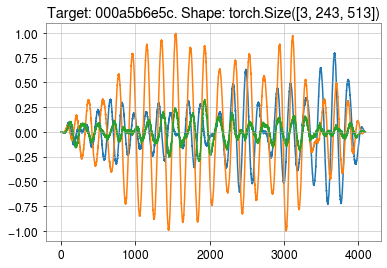

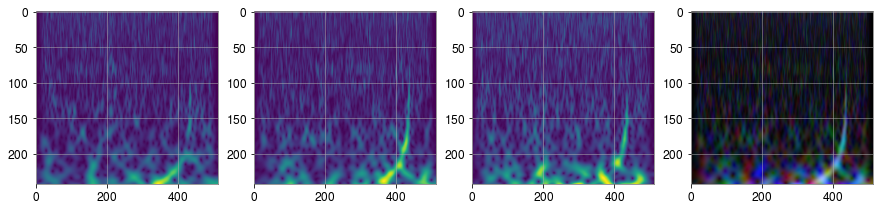

In [24]:
make_plot(wave_id)  # 96 = 000a5b6e5c. Strong chirp

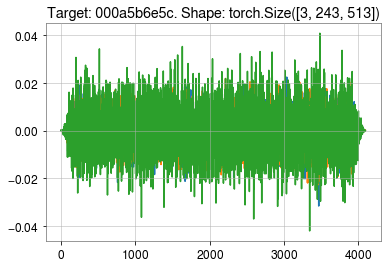

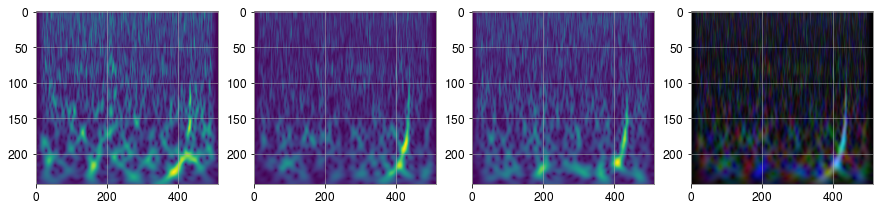

In [25]:
make_plot(wave_id, bandpass=True)  # 96 = 000a5b6e5c. Strong chirp

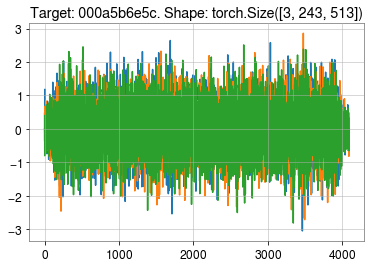

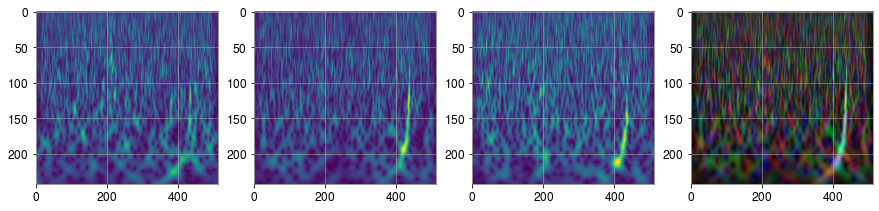

In [26]:
make_plot(wave_id, whiten=True, bandpass=True)  # 96 = 000a5b6e5c. Strong chirp